# Importing necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [23]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#  Data Loading and Inspection



> Load the MPU dataset and display basic information to understand the structure and data types, as well as summary statistics to get an overview of the data.



In [3]:
df = pd.read_excel("mpuData.xlsx")

In [4]:
df.head()

,Movement_Name,Movement_Label,Label_Value,Joint_Label,Pitch,Roll,AccelX,AccelY,AccelZ
0,Stretching,True,1,Shoulder,-0.25,-0.01,-0.02,0.01,9.78
1,Stretching,True,1,Elbow,0.91,-0.17,-0.03,0.00,9.77
2,Stretching,True,1,Wrist,0.57,-0.12,-0.02,0.03,9.75
3,Stretching,True,1,Hand,0.71,-0.11,-0.04,0.05,9.72
4,Stretching,True,1,Shoulder,0.25,-0.07,-0.02,0.02,9.77


In [5]:
df.tail()

,Movement_Name,Movement_Label,Label_Value,Joint_Label,Pitch,Roll,AccelX,AccelY,AccelZ
191,Stretching,False,0,Hand,0.74,3.02,0.52,-0.10,10.42
192,Stretching,False,0,Shoulder,-0.80,0.95,0.26,-0.26,9.91
193,Stretching,False,0,Elbow,0.12,3.24,0.82,0.11,10.27
194,Stretching,False,0,Wrist,-0.13,4.38,0.95,-0.19,10.48
195,Stretching,False,0,Hand,0.59,3.15,0.50,-0.13,10.40


In [6]:
df.sample()

,Movement_Name,Movement_Label,Label_Value,Joint_Label,Pitch,Roll,AccelX,AccelY,AccelZ
136,Stretching,True,1,Shoulder,-0.79,1.1,0.9,-0.33,10.29


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Movement_Name   196 non-null    object 
 1   Movement_Label  196 non-null    bool   
 2   Label_Value     196 non-null    int64  
 3   Joint_Label     196 non-null    object 
 4   Pitch           196 non-null    float64
 5   Roll            196 non-null    float64
 6   AccelX          196 non-null    float64
 7   AccelY          196 non-null    float64
 8   AccelZ          196 non-null    float64
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 12.6+ KB


### Descriptive statistics

In [8]:
df.describe()

,Label_Value,Pitch,Roll,AccelX,AccelY,AccelZ
count,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000
mean,0.489796,-0.261327,2.291327,0.730255,-0.100408,10.104184
std,0.501176,0.867205,1.888887,0.539372,0.205964,0.383193
min,0.000000,-2.240000,-1.610000,-1.000000,-0.570000,8.940000
25%,0.000000,-0.757500,0.780000,0.317500,-0.220000,9.852500
50%,0.000000,-0.235000,2.040000,0.800000,-0.105000,10.240000
75%,1.000000,0.160000,3.460000,1.082500,0.020000,10.392500
max,1.000000,3.350000,7.740000,1.830000,0.510000,10.590000


### Class balance check

In [9]:
df['Movement_Label'].value_counts()

Movement_Label
False    100
True      96
Name: count, dtype: int64

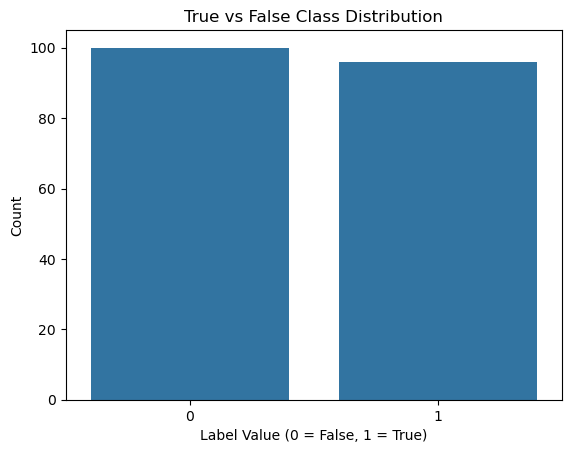

In [10]:
sns.countplot(x="Label_Value", data=df)
plt.title("True vs False Class Distribution")
plt.xlabel("Label Value (0 = False, 1 = True)")
plt.ylabel("Count")
plt.show()

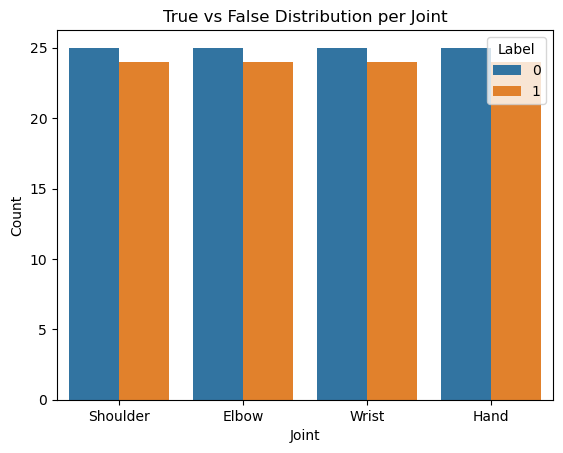

In [11]:
sns.countplot(
    x="Joint_Label",
    hue="Label_Value",
    data=df
)
plt.title("True vs False Distribution per Joint")
plt.xlabel("Joint")
plt.ylabel("Count")
plt.legend(title="Label")
plt.show()


## Data Preprocessing

### Feature Scaling Using StandardScaler

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
# Select numerical feature columns to be scaled
numerical_features = [
    "Pitch",
    "Roll",
    "AccelX",
    "AccelY",
    "AccelZ"
]

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply scaling to the numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])
df.head()

,Movement_Name,Movement_Label,Label_Value,Joint_Label,Pitch,Roll,AccelX,AccelY,AccelZ
0,Stretching,True,1,Shoulder,0.013094,-1.221471,-1.394540,0.537427,-0.848173
1,Stretching,True,1,Elbow,1.354151,-1.306394,-1.413128,0.488751,-0.874336
2,Stretching,True,1,Wrist,0.961082,-1.279855,-1.394540,0.634780,-0.926663
3,Stretching,True,1,Hand,1.122934,-1.274547,-1.431715,0.732133,-1.005153
4,Stretching,True,1,Shoulder,0.591136,-1.253317,-1.394540,0.586103,-0.874336


## Feature Engineering

In [14]:
# Calculate acceleration magnitude to represent motion intensity
df['Accel_Mag'] = np.sqrt(
    df['AccelX']**2 +
    df['AccelY']**2 +
    df['AccelZ']**2
)

In [15]:
# Calculate absolute difference between Pitch and Roll
df['Angle_Diff'] = np.abs(df['Pitch'] - df['Roll'])
df.head() 

,Movement_Name,Movement_Label,Label_Value,Joint_Label,Pitch,Roll,AccelX,AccelY,AccelZ,Accel_Mag,Angle_Diff
0,Stretching,True,1,Shoulder,0.013094,-1.221471,-1.394540,0.537427,-0.848173,1.718420,1.234565
1,Stretching,True,1,Elbow,1.354151,-1.306394,-1.413128,0.488751,-0.874336,1.732129,2.660544
2,Stretching,True,1,Wrist,0.961082,-1.279855,-1.394540,0.634780,-0.926663,1.790640,2.240938
3,Stretching,True,1,Hand,1.122934,-1.274547,-1.431715,0.732133,-1.005153,1.896354,2.397481
4,Stretching,True,1,Shoulder,0.591136,-1.253317,-1.394540,0.586103,-0.874336,1.747205,1.844453


In [30]:

joint_agg = df.groupby(['Movement_Name', 'Joint_Label', 'Label_Value']).agg({
    'AccelX': ['mean', 'std'],
    'AccelY': ['mean', 'std'],
    'AccelZ': ['mean', 'std'],
    'Pitch': ['mean', 'std'],
    'Roll': ['mean', 'std'],
    'Accel_Mag': ['mean', 'std'],
    'Angle_Diff': ['mean', 'std']
}).reset_index()

# Flatten columns
joint_agg.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in joint_agg.columns]

# Rename Label_Value to Target
joint_agg.rename(columns={'Label_Value': 'Target'}, inplace=True)


print("New counts in joint_agg:")
print(joint_agg['Target'].value_counts())

New counts in joint_agg:
Target
0    8
1    8
Name: count, dtype: int64


### Train-Test Split & Preprocessing (One-Hot Encoding for Joint Labels)

In [31]:
# 1. Encoding using OneHotEncoder 
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# Apply to aggregated data
joint_encoded = encoder.fit_transform(joint_agg[['Joint_Label']])
joint_encoded_df = pd.DataFrame(joint_encoded, columns=encoder.get_feature_names_out(['Joint_Label']))

# Combine it back
X = pd.concat([joint_agg.drop(['Movement_Name', 'Joint_Label', 'Target'], axis=1), joint_encoded_df], axis=1)
y = joint_agg['Target']

# 2. Train-Test Split (Keep the distribution with Stratify)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Scaling (Essential for Accuracy)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data is split and scaled. Ready for training!")

✅ Data is split and scaled. Ready for training!


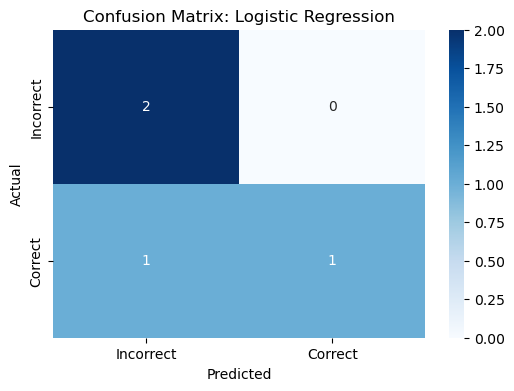

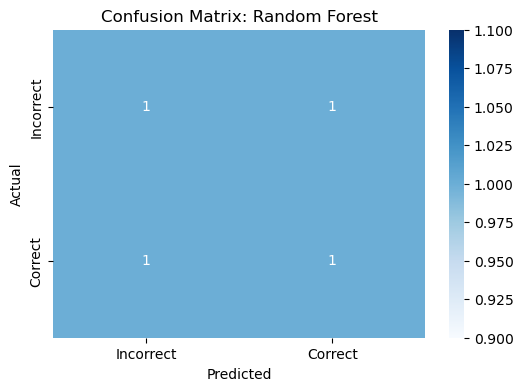

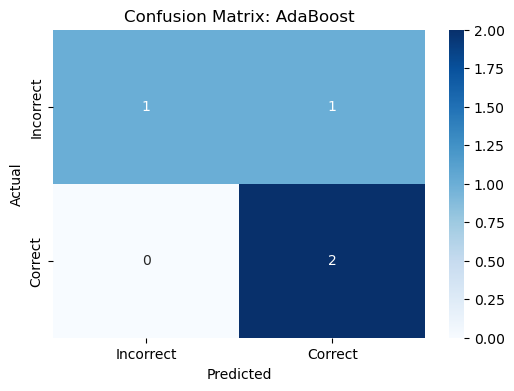

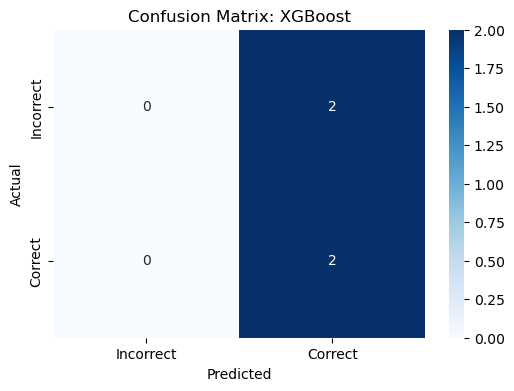


--- Model Performance Comparison ---


,Model Name,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.75,1.000000,0.5,0.666667
1,Random Forest,0.50,0.500000,0.5,0.500000
2,AdaBoost,0.75,0.666667,1.0,0.800000
3,XGBoost,0.50,0.500000,1.0,0.666667



⭐ Best Model Selected: AdaBoost


In [35]:
# 1. Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}
# Lists to store results
results_list = []

# 2. Training and Evaluation Loop
for name, model in models.items():
    # Fit the model on the scaled data
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    metrics = {
        "Model Name": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred)
    }
    results_list.append(metrics)
    
    # --- Plot Confusion Matrix for Each Model ---
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Incorrect', 'Correct'], 
                yticklabels=['Incorrect', 'Correct'])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# 3. Create Comparison Table
results_df = pd.DataFrame(results_list)
print("\n--- Model Performance Comparison ---")
display(results_df)

# 4. Identify the Best Model based on F1-score
best_model_name = results_df.loc[results_df['F1-score'].idxmax(), 'Model Name']
best_model = models[best_model_name]
print(f"\n⭐ Best Model Selected: {best_model_name}")

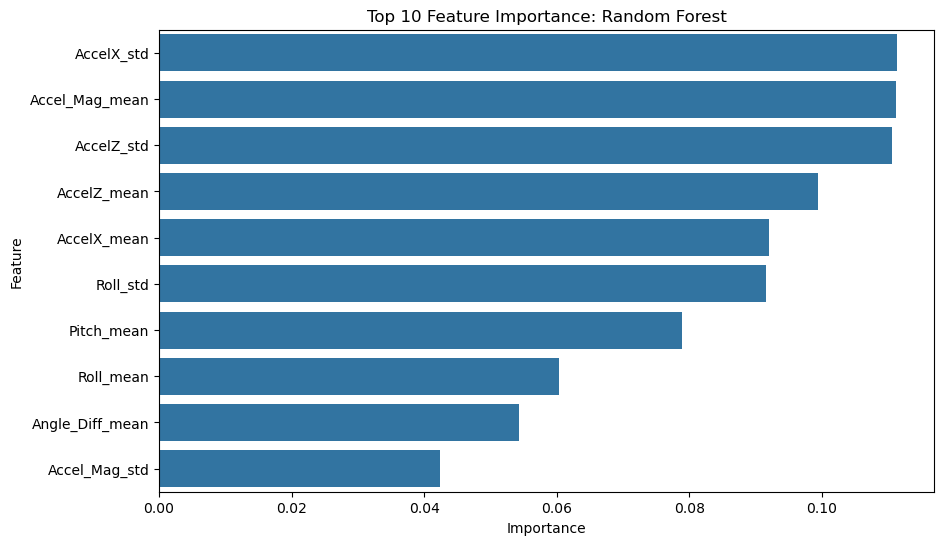

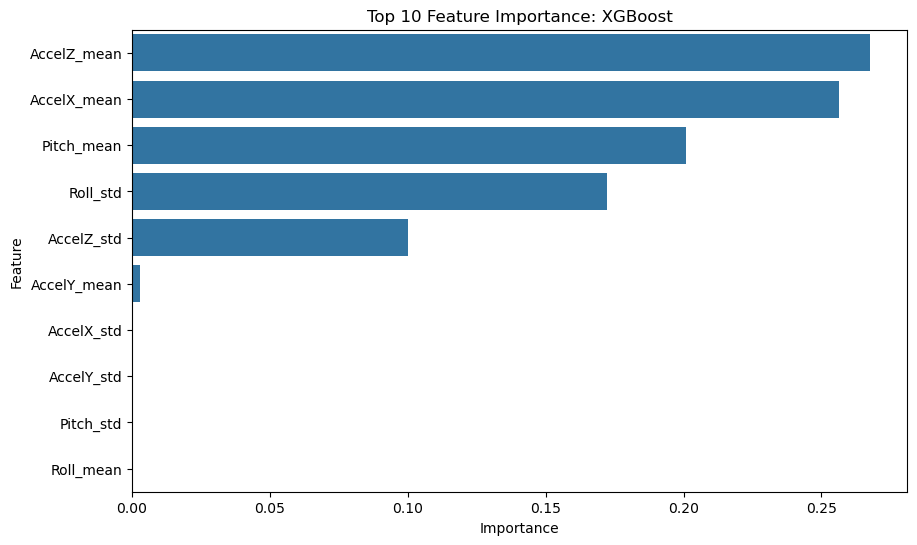

In [36]:
# --- Feature Importance for Tree-Based Models ---
tree_models = ["Random Forest", "XGBoost"]

for name in tree_models:
    plt.figure(figsize=(10, 6))
    importances = models[name].feature_importances_
    feat_names = X.columns
    
    importance_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
    
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
    plt.title(f'Top 10 Feature Importance: {name}')
    plt.show()

In [37]:
# Save the Best Model using .joblib 
model_filename = 'best_motion_classifier_v1.joblib'
joblib.dump(best_model, model_filename)

# Save the Scaler (Must be saved to process future real-time data)
scaler_filename = 'motion_scaler_v1.joblib'
joblib.dump(scaler, scaler_filename)

print(f"✅ Model and Scaler successfully exported to disk.")

✅ Model and Scaler successfully exported to disk.
